In [63]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import datetime as dt

import plotly.io as pio
pio.renderers.default= 'notebook_connected'
import plotly.express as px
import plotly.graph_objects as go




<div id="current_date"></p>
Today's date:
<script>
document.getElementById("current_date").innerHTML = Date();
</script>
</div>


In [64]:
print(str(pd.to_datetime(dt.datetime.today().date()))[:10])

2022-07-21


In [65]:
url = "https://www.sunrise-and-sunset.com/en/sun" #Set url 
df= pd.read_html(url)[0] #Read the dataset


#Cleaning

df= df.droplevel(1,axis=1) #drop unnecessary column levels
df=df.query("Sunrise!='midnight sun' & Sunset!='midnight sun'" )#Drop midnightsun cities
df= df.drop_duplicates("Country",keep="first") #drop duplicates


df.sort_values("Day length")

,City,Country,Sunrise,Sunset,Day length
221,Stanley,Falkland Islands,08:44,17:11,08:27
132,Wellington,New Zealand,07:39,17:15,09:35
138,Canberra,Australia,07:07,17:12,10:04
68,Montevideo,Uruguay,07:47,17:54,10:07
0,Buenos Aires,Argentina,07:55,18:04,10:08
...,...,...,...,...,...
207,Mariehamn,Åland,04:56,22:35,17:38
117,Helsinki,Finland,04:35,22:16,17:40
204,Tórshavn,Faroe Islands,04:25,22:39,18:14
163,Reykjavík,Iceland,04:00,23:04,19:03


In [66]:
#Convert to datetime format
times= df.columns[2:]
for i in times:
    df[i]= pd.to_datetime(df[i], format="%H:%M")

# Density plots (Histogram + Kernel) for Sunrise, Sunset and Day Length

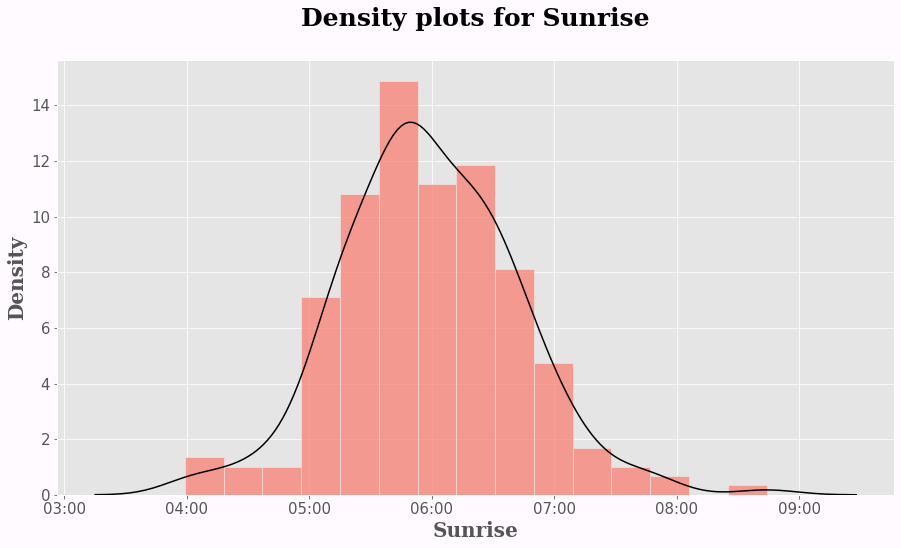

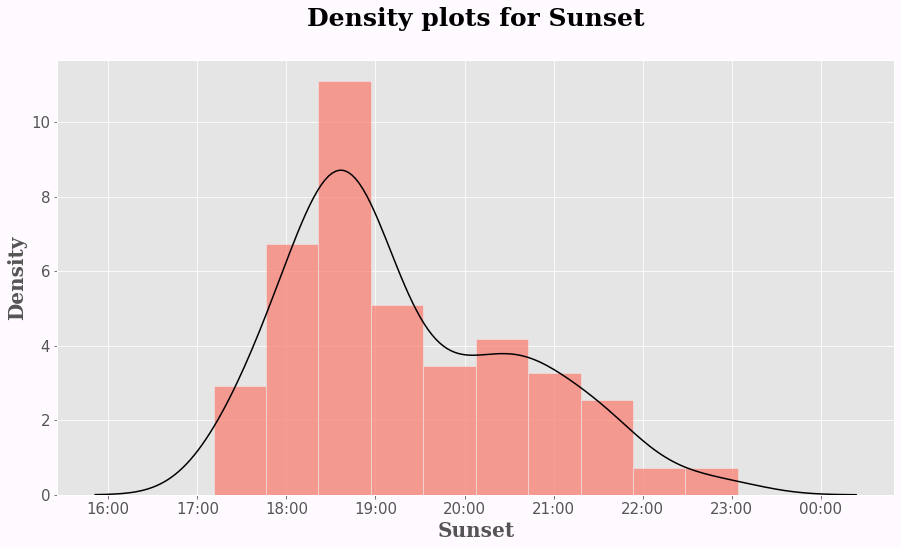

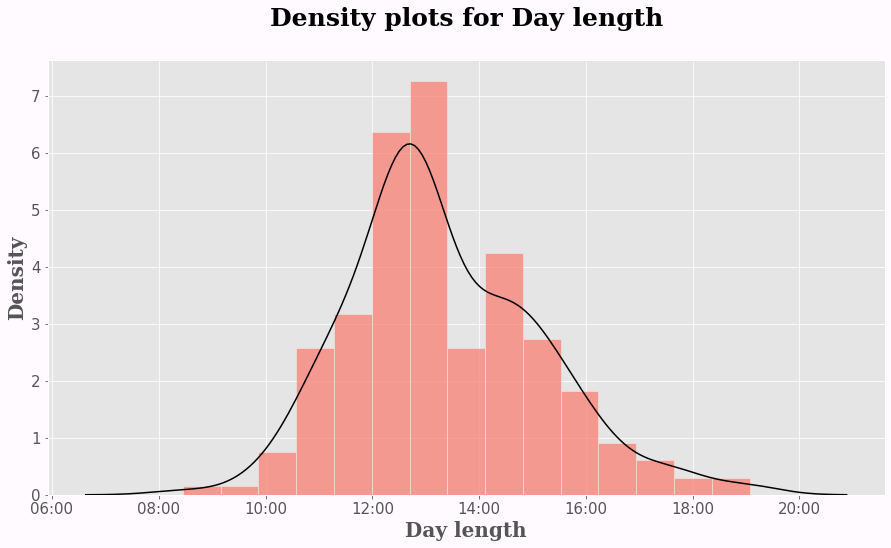

In [67]:
def _hist(col:str):
    fig,ax= plt.subplots(figsize=(15,8))
    xformatter = mdates.DateFormatter('%H:%M') #format dates for axes labels
    


    sns.histplot(data=df, x=col,ax=ax,color='salmon',stat='density') #Plot histogram
    sns.kdeplot(data=df, x=col,ax=ax,color='k') #Plot Kernel Density
    
    #Format titles, labels and background color
    ax.set_title("Density plots for "+ col +"\n", loc='center', fontsize=25, fontweight="bold",family='serif')
    ax.xaxis.set_major_formatter(xformatter)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel(col,fontsize=20, fontweight="bold",family='serif')
    ax.set_ylabel('Density',fontsize=20, fontweight="bold",family='serif')
    fig.set_facecolor(tuple(np.array([255, 250, 255]) / 255))



_hist("Sunrise")
_hist("Sunset")
_hist("Day length")


# Scatter plot and Regression Line for Sunrise and Sunset

In [68]:
#In this section of code, we convert datetime values to seconds for the following purposes:
#   1) Sunrise and Sunset values need to be converted to seconds to run the regression
#   2) Day length values need to be converted to seconds for the scatterplot (In the scatterplot, the size and color of the points varries with the magnitude of Daylength)

def to_sec(col):
    """
    This function converts the datetime values to seconds

    Input: Relevant series with datetime values values need to be converted to seconds
    Output: Updated series with values in seconds
    """
    col_up= pd.to_timedelta(
        col-pd.to_datetime("1900-01-01 00:00:00")).dt.total_seconds() #convert datetime values to timedelta and then calculate total seconds
    return col_up

#Make new columns for Day length, Sunset and Sunrise which have values in seconds
df["Day l_sec"]= to_sec(df["Day length"])
df["Sunset_sec"]= to_sec(df["Sunset"])
df["Sunrise_sec"]= to_sec(df["Sunrise"])


In [69]:
def to_times(s):
    v= pd.to_datetime(dt.datetime.fromtimestamp(s))-pd.to_datetime("1970-01-01 05:00:00")
    return v
    
def to_dt(col):
    col_up= col.apply(to_times)
    col_up= col_up.astype(str).map(lambda x: x[7:12])
    col_up=pd.to_datetime(col_up,format="%H:%M")
    return col_up


In [70]:
reg = smf.ols('Q("Sunset_sec") ~ Q("Sunrise_sec")',df).fit()
df['yhat'] = reg.predict()
df['yhat']= to_dt(df["yhat"])

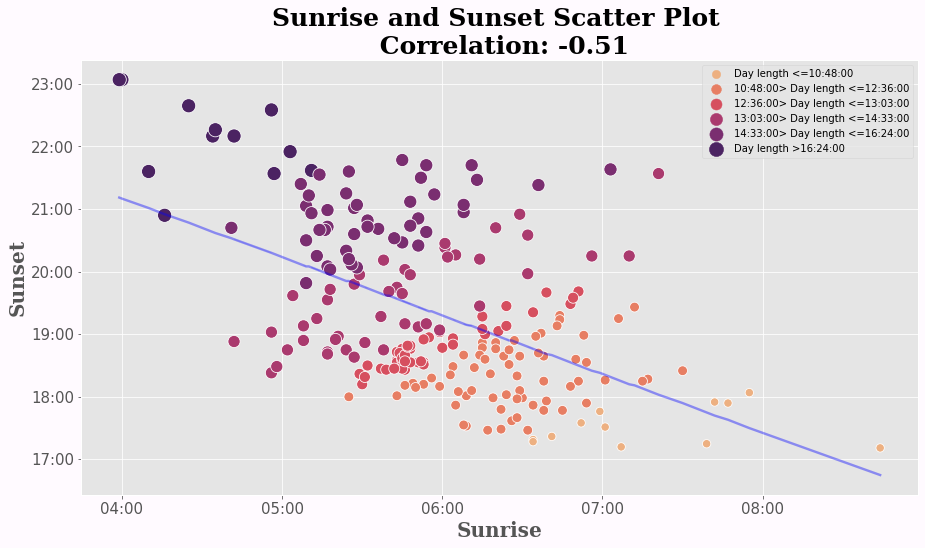

In [71]:
fig,ax= plt.subplots(figsize=(15,8))
xformatter = mdates.DateFormatter('%H:%M')

df["cols"]= np.where(df["Day l_sec"]<=df["Day l_sec"].quantile(0.05),1,6)
df["cols"]= np.where((df["Day l_sec"]>df["Day l_sec"].quantile(0.05)) & (df["Day l_sec"]<=df["Day l_sec"].quantile(0.35)),2,df["cols"])
df["cols"]= np.where((df["Day l_sec"]>df["Day l_sec"].quantile(0.35)) & (df["Day l_sec"]<=df["Day l_sec"].quantile(0.55)),3,df["cols"])
df["cols"]= np.where((df["Day l_sec"]>df["Day l_sec"].quantile(0.55)) & (df["Day l_sec"]<=df["Day l_sec"].quantile(0.75)),4,df["cols"])
df["cols"]= np.where((df["Day l_sec"]>df["Day l_sec"].quantile(0.75)) & (df["Day l_sec"]<=df["Day l_sec"].quantile(0.95)),5,df["cols"])


sns.scatterplot(data=df,x="Sunrise",y="Sunset",hue="cols",size="cols",ax=ax,legend='full',sizes=(70, 200),palette="flare")

def dayl_to_str(q):
    s= df["Day l_sec"].quantile(q).round(2)
    s= pd.to_datetime(dt.datetime.fromtimestamp(s))-pd.to_datetime("1970-01-01 05:00:00")
    s= str(s)[7:12]+":00"
    return s

new_labels= ["Day length <="+str(dayl_to_str(0.05)),
        str(dayl_to_str(0.05))+"> Day length <=" +str(dayl_to_str(0.35)),
        str(dayl_to_str(0.35))+"> Day length <=" +str(dayl_to_str(0.55)),
        str(dayl_to_str(0.55))+"> Day length <=" +str(dayl_to_str(0.75)),
        str(dayl_to_str(0.75))+"> Day length <=" +str(dayl_to_str(0.95)),
        "Day length >" +str(dayl_to_str(0.95))]

leg= ax.get_legend()
leg.set_title("")

leg.prop.set_size(10)
leg.prop.set_family('serif')

for t, l in zip(leg.texts, new_labels):
    t.set_text(l)


sns.lineplot(data=df,x="Sunrise",y="yhat",ax=ax, lw=2.4, color=(0,0,1,0.4),legend=False)



cor= df[["Sunset_sec","Sunrise_sec"]].corr().iloc[0,1].round(2)
ax.set_title("Sunrise and Sunset Scatter Plot \n Correlation: "+str(cor),loc='center', fontsize=25, fontweight="bold",family='serif')
ax.set
ax.xaxis.set_major_formatter(xformatter)
ax.yaxis.set_major_formatter(xformatter)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel("Sunrise",fontsize=20, fontweight="bold",family='serif')
ax.set_ylabel('Sunset',fontsize=20, fontweight="bold",family='serif')

fig.set_facecolor(tuple(np.array([255, 250, 255]) / 255))





#Later sunrises lead to earlier sunsets (shorter days/longer nights)


In [72]:
ds = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv').iloc[:,[0,2]]
ds= ds.rename(columns={"COUNTRY":"Country"})

df_m= df.loc[:,["Country","Day l_sec","Sunset_sec","Sunrise_sec"]].merge(ds,on="Country",how='left').set_index('Country')

#Add codes for missing values
dicto={
    'South Korea':'KOR',
    'Congo-Kinshasa':'COD',
    'North Korea':'PRK',
    'Congo-Brazzaville':'COG',
    'Myanmar':'MMR',
    'Bahamas':'BHM',
    'Ivory Coast':'CIV',
    'East Timor':'TLS',
    'Reunion':"REU",
    'Curaçao':'CUR',
    'Cape Verde':'CPV',
    'Martinique':"MTQ",
    'French Guiana':"GUF",
    'Mayotte':",YT",
    'São Tomé and Príncipe':'STP',
    'Gambia':'GMB',
    'U.S. Virgin Islands':'VGB',
    'Guadeloupe':"GLP",
    'Åland':"ALA",
    'Saint Barthélemy':"BLM",
    'Micronesia':"FSM",
    'Turks and Caicos Islands':"TCA",
    'Falkland Islands':'FLK',
    'Wallis and Futuna':""}


for i in dicto.keys():
    df_m.loc[i,"CODE"]= dicto[i]

df_m= df_m.reset_index()

df_m= df_m.rename(columns={"Day l_sec":"Day length","Sunset_sec":"Sunset","Sunrise_sec":"Sunrise"})

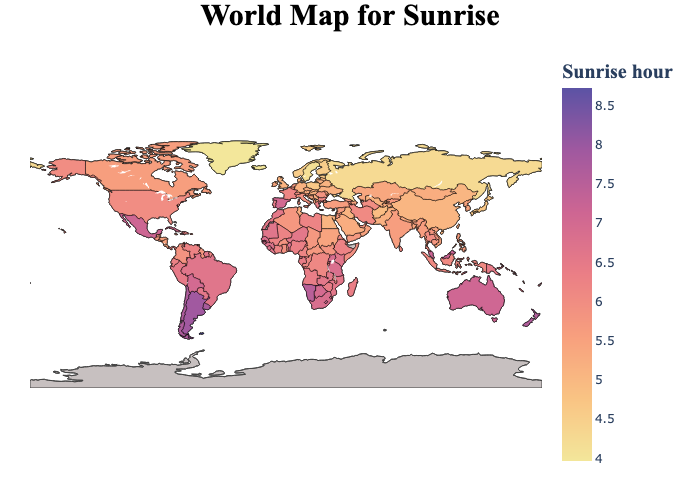

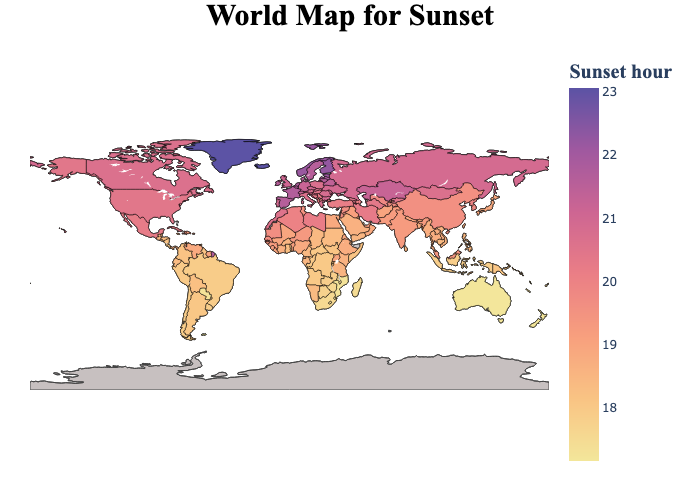

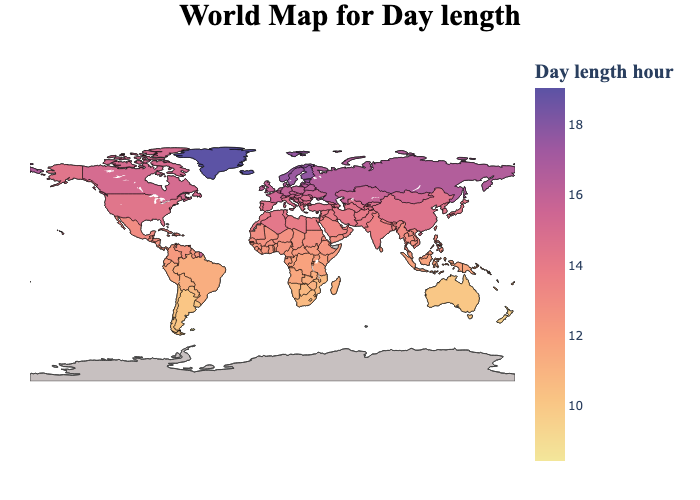

In [73]:
def map(col):
    fig = go.Figure(data=go.Choropleth(
        locations = df_m['CODE'], #locations identified based on country code
        z = (df_m[col]/3600).round(2),        #color varies based on magnitude of index
        text = df_m['Country'], 
        colorscale = 'sunset_r',
        autocolorscale=False,
        reversescale=True,
        marker_line_color='black',
        marker_line_width=0.5,
        colorbar=dict(title={'text':'<b>'+col+ ' hour </b>','font':{'size':20,'family':'serif'}})
        ))

    fig.update_layout(
        title_text='<b>World Map for '+col,
        titlefont=dict(size =30, color='black', family='serif'),
        title_x=0.5,
        geo=dict(
        landcolor = 'rgba(175, 165, 166,0.7)', #customize grey color with missing values
        showcountries = True,
        showframe=False,
        showcoastlines=True,
        bgcolor='rgb(255,255,255)' #customize background color to our default value
        ),
        margin=dict(l=30, r=30, t=50, b=30),
        paper_bgcolor='rgb(255,255,255)',
    )

    fig.show("png")



map("Sunrise")
map("Sunset")
map("Day length")

In [74]:
! jupyter nbconvert --to webpdf --no-input Sunsets_and_sunrises.ipynb

[NbConvertApp] Converting notebook Sunsets_and_sunrises.ipynb to webpdf
[NbConvertApp] Writing 489940 bytes to Sunsets_and_sunrises.pdf
